In [1]:
import pandas as pd
import numpy as np
import math
import os
import matplotlib.pyplot as plt

# -------------------------
# SECTION 1: LOAD DATA
# -------------------------

data_dir = 'data'

# Load flue gas properties using provided syntax
gas_props = pd.read_csv(os.path.join(data_dir, 'FG_flue_gas_properties_1700K.csv'))
props = {col: gas_props[col].values[5] for col in gas_props.columns}

cp_mixture = props['cp [kJ/kg.K]']
gamma_mixture = props['gamma']
R_mix = props['R [kJ/kg.K]']
mu_mix = gas_props.loc[gas_props['Gas'] == 'Viscosity [Pa.s]', 'cp [kJ/kg.K]'].values[0]
mass_flow_air = gas_props.loc[gas_props['Gas'] == 'm_dot_core [kg/s]', 'cp [kJ/kg.K]'].values[0]
mass_flow_fuel = gas_props.loc[gas_props['Gas'] == 'm_dot_fuel [kg/s]', 'cp [kJ/kg.K]'].values[0]

# Input parameters
cooling_air = 0.10
P0t = 40  # bar
ExpRatio_tot = 2
P2t = P0t / ExpRatio_tot

mass_flow_total = mass_flow_air / (1 - cooling_air) + mass_flow_fuel

# Load station 0 and 2 mass-averaged data
turbineInputs = pd.read_csv(os.path.join(data_dir, 'TM_turbine_inputs.csv'), header=None, index_col=0).squeeze()
station0 = pd.read_csv(os.path.join(data_dir, 'TM_station0_results.csv'), header=None, index_col=0).squeeze()
station2 = pd.read_csv(os.path.join(data_dir, 'TM_station2_results.csv'), header=None, index_col=0).squeeze()
station1 = pd.read_csv(os.path.join(data_dir, 'TM_station1_results.csv'), header=None, index_col=0).squeeze()

# Extract values
T0t = station0['T0t']
P0t = station0['P0t']
T2t = station2['T2t']
omega = turbineInputs['omega'] # RPM
P_euler_calculated = mass_flow_total * cp_mixture * (T0t-T2t)



In [2]:
# -------------------------
# SECTION 2: COMPRESSOR THERMODYNAMICS
# -------------------------

LHV_fuel = 43e3
cp_air = 1.005
cv_air = 0.718
gamma_air = cp_air / cv_air
bleed_percentage = 0.1
cp_fuel = 2.0
T_fuel = T_ref = 25 + 273.15
eta_tt_comp = 0.9

mass_flow_air_into_comb = (1 - bleed_percentage) * mass_flow_air

Tout_t_comp = (((mass_flow_air_into_comb + mass_flow_fuel) * cp_mixture * (T0t - T_ref)
                - mass_flow_fuel * (LHV_fuel + cp_fuel * (T_fuel - T_ref)))
               / (cp_air * mass_flow_air_into_comb)) + T_ref

Pout_t_comp = P0t
Tin_t_comp = Tout_t_comp - (P_euler_calculated / (mass_flow_air * cp_air))
Tout_t_comp_is = eta_tt_comp * (Tout_t_comp - Tin_t_comp) + Tin_t_comp
CR = (Tout_t_comp_is / Tin_t_comp) ** (gamma_air / (gamma_air - 1))
Pin_t_comp = Pout_t_comp / CR

comp_ratio_per_stage = 1.2
N_stages_HPC = math.ceil(math.log(CR) / math.log(comp_ratio_per_stage))
comp_ratio_per_stage_new = CR ** (1 / N_stages_HPC)
P_comp_required = mass_flow_air * cp_air * (Tout_t_comp - Tin_t_comp)

# Save summary
comp_summary = pd.DataFrame({
    'parameter': [
        'Tout_t_comp', 'Pout_t_comp', 'Tin_t_comp', 'CR', 'Pin_t_comp',
        'comp_ratio_per_stage', 'N_stages_HPC', 'comp_ratio_per_stage_new',
        'P_euler_calculated', 'P_comp_required'
    ],
    'value': [
        Tout_t_comp, Pout_t_comp, Tin_t_comp, CR, Pin_t_comp,
        comp_ratio_per_stage, N_stages_HPC, comp_ratio_per_stage_new,
        P_euler_calculated, P_comp_required
    ]
})
comp_summary.to_csv(os.path.join(data_dir, 'CO_comp_summary.csv'), index=False)





In [5]:
# -------------------------
# SECTION 3: GEOMETRY
# -------------------------

R_air = 287
RD_vavra = 0.6
FC_vavra = 0.6
WC_vavra = 0.3

comp_omega_radians = omega * 2 * math.pi / 60
Ttc_inlet = Tin_t_comp
Tout_t_target = Tout_t_comp
m_dot = mass_flow_air
cp = cp_air

delta_T_total = Tout_t_target - Ttc_inlet
delta_T_per_stage = delta_T_total / N_stages_HPC
L_euler_compressor_perStage = cp * delta_T_per_stage
U_comp = math.sqrt(L_euler_compressor_perStage * 1000 / WC_vavra)
Vax_c = FC_vavra * U_comp
r_mean_c = U_comp / comp_omega_radians

results = []
Ttc = Ttc_inlet
Ptc = Pin_t_comp
b_blades = []

for stage in range(1, N_stages_HPC + 2):
    Ptc_next = Ptc * comp_ratio_per_stage_new
    Ttc_next = Ttc + delta_T_per_stage
    Dht = cp * (Ttc_next - Ttc)
    Tstat = Ttc - (Vax_c ** 2 / (2 * cp * 1000))
    M_axial = Vax_c / math.sqrt(gamma_air * R_air * Tstat)
    Pstat = Ptc / (1 + ((gamma_air - 1)/2) * M_axial**2)**(gamma_air / (gamma_air - 1))
    rho = (Pstat * 1e5) / (R_air * Tstat)
    b_blade = m_dot / (2 * math.pi * r_mean_c * rho * Vax_c)

    b_blades.append(b_blade)
    results.append([stage, Ptc, Ttc, Dht, Tstat, M_axial, Pstat, rho, b_blade])

    Ptc = Ptc_next
    Ttc = Ttc_next

columns = ['Stage', 'Ptc [bar]', 'Ttc [K]', 'Δh [kJ/kg]', 'Tstat [K]',
           'Mach_axial', 'Pstat [bar]', 'rho [kg/m³]', 'Blade H. [m]']
geom_df = pd.DataFrame(results, columns=columns)
print(geom_df)
geom_df.to_csv(os.path.join(data_dir, 'CO_comp_geometry.csv'), index=False)

   Stage  Ptc [bar]      Ttc [K]  Δh [kJ/kg]    Tstat [K]  Mach_axial  \
0      1  16.364342  1024.227173   66.511389   984.518881    0.449226   
1      2  19.567297  1090.407660   66.511389  1050.699368    0.434848   
2      3  23.397159  1156.588147   66.511389  1116.879855    0.421768   
3      4  27.976631  1222.768634   66.511389  1183.060342    0.409801   
4      5  33.452433  1288.949121   66.511389  1249.240829    0.398799   
5      6  40.000000  1355.129608   66.511389  1315.421316    0.388637   

   Pstat [bar]  rho [kg/m³]  Blade H. [m]  
0    14.248390     5.042662      0.049915  
1    17.183685     5.698439      0.044170  
2    20.703021     6.458704      0.038971  
3    24.922383     7.340080      0.034291  
4    29.980606     8.362042      0.030101  
5    36.043888     9.547394      0.026363  


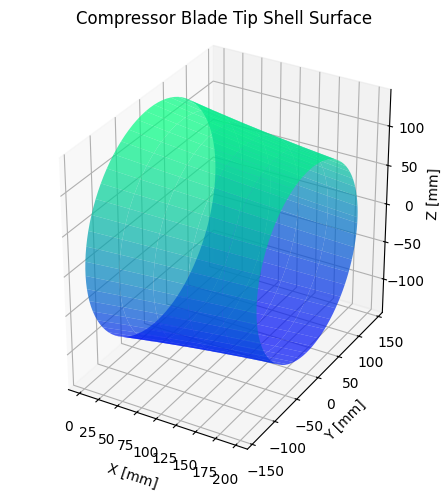

In [4]:
# -------------------------
# SECTION 4: BLADE TIP SHELL PLOT
# -------------------------

b_blades_mm = np.array(b_blades) * 1000
radii = b_blades_mm + 90
nStages = len(radii)
nPoints = 100
spacing = 40

theta = np.linspace(0, 2 * np.pi, nPoints)
X, Y, Z = np.zeros((nStages, nPoints)), np.zeros((nStages, nPoints)), np.zeros((nStages, nPoints))

for i in range(nStages):
    X[i, :] = i * spacing
    Y[i, :] = radii[i] * np.cos(theta)
    Z[i, :] = radii[i] * np.sin(theta)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z, alpha=0.7, edgecolor='none', cmap='winter')
ax.set_title('Compressor Blade Tip Shell Surface')
ax.set_xlabel('X [mm]')
ax.set_ylabel('Y [mm]')
ax.set_zlabel('Z [mm]')
ax.set_aspect('equal')
plt.tight_layout()
plt.show()